# Description

The UCI Machine Learning dataset repository hosts several datasets recording word counts for documents at https://archive.ics.uci.edu/ml/datasets/Bag+of+Words. Usinbg the NIPS dataset I will:
- find a table of word counts per document 
- find a vocabulary list for this dataset at the link

For this problem, I will write the clustering code by myself (i.e. not use a package for clustering)

---

# Imports

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from scipy.special import logsumexp

# Data

## Description
There are multiple collection of word-count datasets available at https://archive.ics.uci.edu/ml/datasets/Bag+of+Words . I will be using the NIPS collection of words. This dataset is composed of papers presented at the Conference of Neural Information Processing Systems

## Information Summary

* **Input/Output**: There are a total of 12419 words counted, and 1500 documents were surveyed. Therefore, the data can be stored in a count array with a shape of `(1500, 12419)`.

* **Missing Data**: There is no missing data.

* **Final Goal**: To fit an EM topic model for clustering the documents.

In [8]:
with open(f'Data/WordNips.txt') as fh:
    for line_num, line in enumerate(fh):
        if line_num == 0:
            N = int(line) # Number of documents
        elif line_num == 1:
            d = int(line) # Number of words
            X = np.zeros((N, d))
        elif line_num == 2:
            NNZ = int(line)
        else:
            doc_id, word_id, count = tuple([int(a) for a in line.split(' ')])
            X[doc_id-1, word_id-1] = count

assert X[X>0].size == NNZ

In [9]:
with open(f'Data/VocabNips.txt') as fh2:
    words = [line.rstrip() for line in fh2]
    
assert len(words) == d

# Implementing the EM Topic Model
I will implement and describe every function, one at a time, and combine everything at the end

## E-step

Function `find_logW` calculates the $\log W_{i,j}$ matrix, and takes the following arguments as input:

1. `X`: A numpy array of the shape `(N,d)` where `N` is the number of documents and `d` is the number of words
2. `log_P`: A numpy array of the shape `(t,d)` where `t` is the number of topics for clustering and `d` is the number of words. 
3. `log_pi`: A numpy array of the shape `(t,1)` where `t` is the number of topics for clustering. 

Function returns the numpy array `log_W` with the shape of `(N, t)` whose $i^{th}$ row and $j^{th}$ column should be
$$\log W_{i,j} = \log\bigg(\frac{\pi_j \prod_{k=1}^{d} P_{j,k}^{x_{i,k}}}{\sum_{l=1}^{t} \pi_l \prod_{k=1}^{d} P_{l,k}^{x_{i,k}}}\bigg).$$

In [11]:
def find_logW(X, log_P, log_pi):
    N, d = X.shape
    
    log_R = np.ones((N, 1)) @ log_pi.T + X @ log_P.T
    log_S = logsumexp(log_R, axis=1, keepdims=True)
    log_W = log_R - log_S
    
    return log_W

## M-step

Function `update_logP` does the maximization step for the $\log P_{i,j}$ matrix, and takes the following arguments as input:

1. `X`: A numpy array of the shape `(N,d)` where `N` is the number of documents and `d` is the number of words
2. `log_W`: A numpy array of the shape `(N,t)` where `N` is the number of documents and `t` is the number of topics for clustering
3. `eps`: A very small $\epsilon$ scalar added to make sure the log operation has enough numerical stability
$$E_{t\times d} = [W^T]_{t\times N} \cdot X_{N\times d} + \epsilon.$$

Function returns the numpy array `log_P` with the shape of `(t, d)` whose $j^{th}$ row should be
$$\log \mathbf{p}_j = \log \left(\frac{\sum_{i=1}^{N} \mathbf{x}_i W_{i,j}}{\sum_{i=1}^{N} (\mathbf{x}_i^T\mathbf{1}) W_{i,j}}\right).$$

In [12]:
def update_logP(X, log_W, eps=1e-100):
    N, d = X.shape
    t = log_W.shape[1]
    
    E = np.log(np.exp(log_W).T @ X + eps)
    F = logsumexp(E, axis=1, keepdims=True)
    log_P = E - F
    
    return log_P

Function `update_log_pi` does the maximization step for the $\log \pi$ vector, and takes the following arguments as input:

1. `log_W`: A numpy array of the shape `(N,t)` where `N` is the number of documents and `t` is the number of topics for clustering.`log_W` is the same as the output from the previous functions.

Function returns the `log_pi` numpy array with a shape of `(t,1)` whose $j^{th}$ element should be 
$$\log \pi_j = \log\bigg(\frac{\sum_{i=1}^{N} W_{i,j}}{N}\bigg).$$

In [13]:
def update_log_pi(log_W):
    N, t = log_W.shape
    
    log_pi = (logsumexp(log_W, axis=0, keepdims=True) - np.log(N)).reshape(-1,1)
    
    return log_pi

# Running the Topic Model EM Algorithm

In [14]:
def TopicModel(X, t, iterations=100, seed=12345):
    N, d = X.shape

    np_random = np.random.RandomState(seed=seed)
    pi_init = np.ones((t,1))/float(t)
    
    if True:
        P_init = np_random.uniform(0, 1, (t, d))
    else:
        X_copy = X.copy()
        np_random.shuffle(X_copy)
        
        c = N//t
        P_init = np.zeros((t, d))
        for k in range(t):
            P_init[k, :] = (X_copy[(c*k):(c*(k+1)), :]).sum(axis=0) + 1e-1
            
    P_init = P_init/P_init.sum(axis=1).reshape(-1, 1)

    log_pi = np.log(pi_init) # log_pi.shape == (t,1)
    log_P = np.log(P_init) # log_P.shape == (t,d)
    assert log_pi.shape == (t,1)
    
    log_W = None
    for iteration in range(iterations):
        print('.', end='')
        #The E-Step
        log_W = find_logW(X, log_P, log_pi)

        #The M-Step
        log_P = update_logP(X, log_W)
        log_pi = update_log_pi(log_W)
    
    return log_pi, log_P, log_W

Let's use 30 topics and 100 iterations for a start. 

In [15]:
log_pi, log_P, log_W = TopicModel(X, t=30, iterations=100, seed=12345)

....................................................................................................

## Visualizing Topic Frequencies

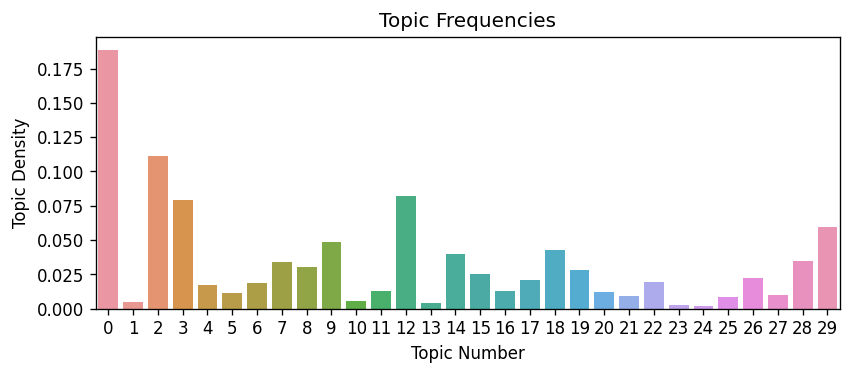

In [16]:
    fig, ax=plt.subplots(figsize=(8,3), dpi=120)
    sns.barplot(x=np.arange(30), y=np.exp(log_pi).reshape(-1), ax=ax)
    ax.set_title(f'Topic Frequencies')
    ax.set_xlabel(f'Topic Number')
    _ = ax.set_ylabel(f'Topic Density')

## Printing The Most Frequent Words in Each Topic

c:\users\wiewi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


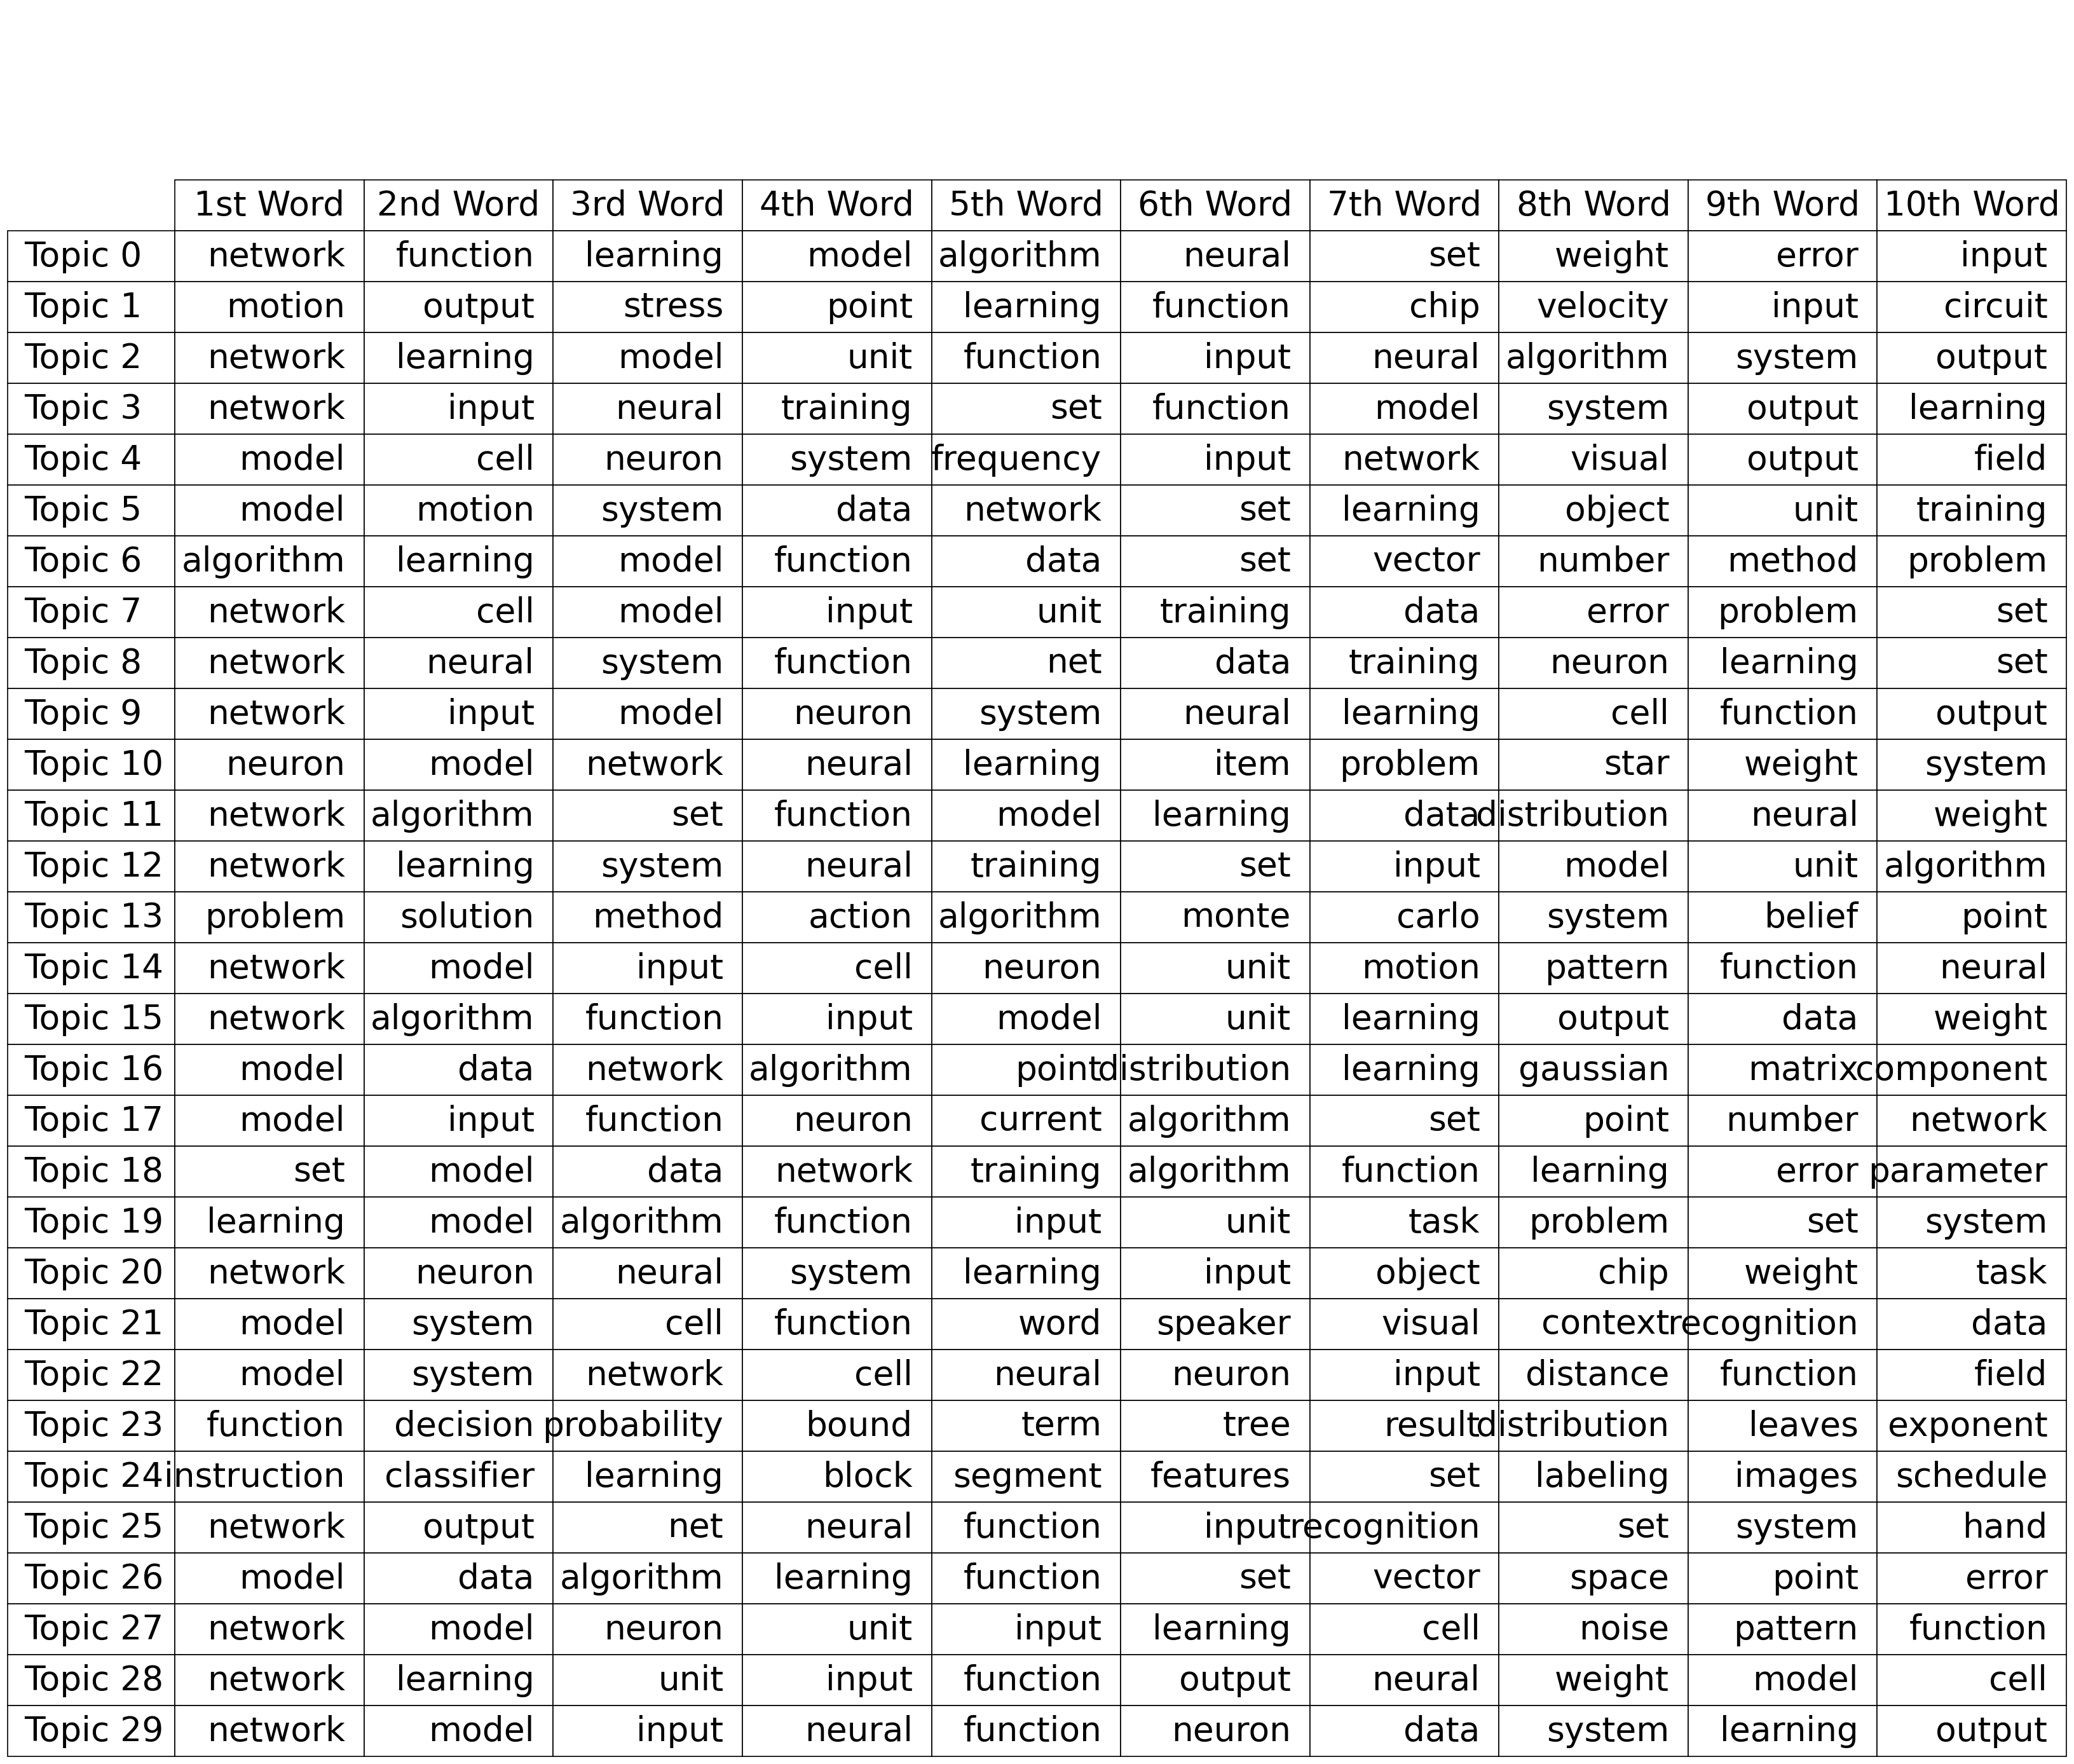

In [19]:
top_indices = np.argsort(log_P, axis=1)[:,::-1][:, :10]
top_words = [[words[x] for x in top_indices_row] for top_indices_row in top_indices]

fig, ax = plt.subplots(figsize=(8,3), dpi=120)
col_labels = ['1st Word', '2nd Word', '3rd Word'] + [f'{i}th Word' for i in range(4,11)]
row_labels = [f'Topic {t_idx}' for t_idx in range(log_P.shape[0])]
table_ = ax.table(top_words, colLabels=col_labels, rowLabels=row_labels)

table_.auto_set_font_size(False)
table_.set_fontsize(32)
table_.scale(4, 4)

# Removing ticks and spines enables to get the figure only with table
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)

fig.tight_layout()